In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from keras.metrics import R2Score
import datetime
from scipy.ndimage import gaussian_filter1d

In [2]:
# Load data from CSV file
data = pd.read_csv('ancf_increament.csv',dtype=float)
print(data.shape)
data.head()
data.describe()


(9995, 20)


,iter,time,Mx,My,Mz,DMx,DMy,DMz,x,y,z,rxx,rxy,rxz,ryx,ryy,ryz,rzx,rzy,rzz
count,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000
mean,7.911456,2.990324,-0.008048,0.006575,0.016790,0.001417,0.003204,0.003087,-0.033719,0.034048,0.288252,-0.195894,0.196942,0.333044,-0.089183,0.191796,0.404370,-0.192792,0.092810,0.409848
std,2.087218,0.836147,5.006388,8.253032,8.277224,1.371797,1.388185,1.386382,0.142497,0.142754,0.090925,0.523654,0.524056,0.512887,0.511696,0.618402,0.384020,0.619400,0.506106,0.382651
min,0.000000,0.000000,-10.195491,-15.829722,-15.856811,-3.295789,-3.380876,-3.367192,-0.275232,-0.172097,0.069044,-0.995756,-0.671556,-0.733329,-0.987038,-0.999974,-0.565188,-0.999981,-0.906924,-0.551798
25%,7.000000,2.427465,-4.275957,-7.112649,-7.073154,-0.990673,-0.987250,-1.001858,-0.176150,-0.101457,0.211699,-0.781877,-0.285932,-0.129485,-0.582103,-0.167508,0.073195,-0.671945,-0.316813,0.077065
50%,7.000000,2.820386,0.056074,-0.002125,0.037876,-0.000535,-0.005465,-0.026685,-0.000998,0.001689,0.306071,-0.067037,0.072320,0.402780,0.002560,0.335049,0.455042,-0.341577,0.009531,0.452912
75%,9.000000,3.528901,4.236027,7.092817,7.152057,0.985094,0.997124,1.008586,0.101095,0.176877,0.373911,0.287582,0.783351,0.828178,0.326492,0.678952,0.755504,0.178903,0.574110,0.757893
max,41.000000,15.753563,10.142904,15.728990,15.829042,3.357955,3.356139,3.319086,0.175732,0.275323,0.400031,0.664287,0.995891,1.000000,0.900572,0.999947,0.998382,0.999984,0.986680,0.996823


In [3]:

# Separate features (X) and labels (y)
positions = data[['x','y', 'z']].to_numpy()#, 'rxx', 'rxy', 'rxz', 'ryx', 'ryy', 'ryz', 'rzx', 'rzy', 'rzz']]  # Features
torques = data[['Mx', 'My','Mz']].to_numpy() #Lable
print(positions.shape)
print(torques.shape)

(9995, 3)
(9995, 3)


In [4]:
def gaussian_smooth(arr, sigma):
    smoothed_arr = gaussian_filter1d(arr, sigma=sigma, axis=0)
    return smoothed_arr


In [8]:
smoothed_positions = gaussian_smooth(positions, 10)

# Convert numpy array to pandas DataFrame
df = pd.DataFrame(smoothed_positions)
# Save DataFrame to .csv
ref_to_save = df[::5]

ref = ref_to_save.to_numpy()

(1999, 3)


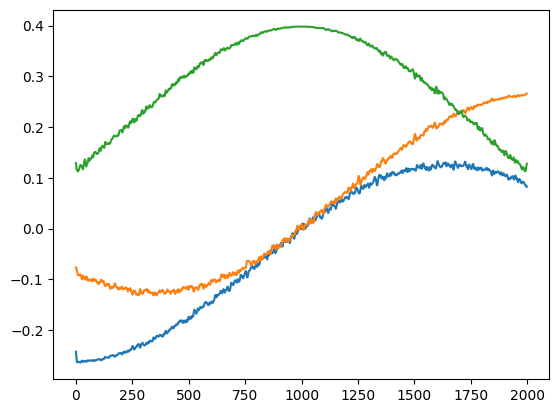

In [10]:

plt.plot(ref[:,0])
plt.plot(ref[:,1])
plt.plot(ref[:,2])
print(ref.shape)
# Save the array as a CSV file
np.savetxt('reference.csv', ref, delimiter=',')
# ref_to_save.to_csv('reference.csv', index=False)

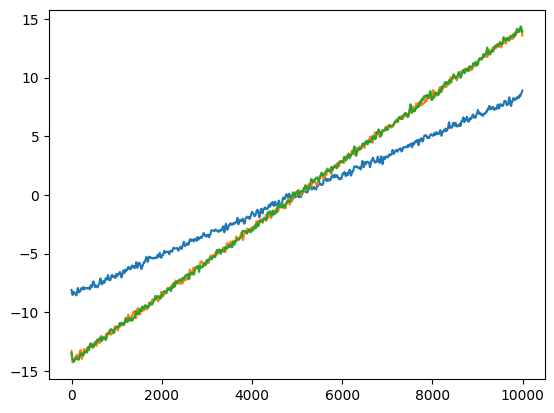

In [9]:
smoothed_torques = gaussian_smooth(torques, 10)
plt.plot(smoothed_torques[:,0])
plt.plot(smoothed_torques[:,1])
plt.plot(smoothed_torques[:,2])


In [10]:
features = np.hstack((smoothed_positions[0:-1,:],smoothed_torques[1:,:]))

print(features.shape)
targets = positions[1:,:]
print(targets.shape)

(9994, 6)
(9994, 3)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(y_val.shape)

(7995, 6)
(7995, 3)
(1999, 3)


In [15]:

# # Normalize input and output data
# X_mean, X_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
# y_mean, y_std = np.mean(y_train, axis=0), np.std(y_train, axis=0)

# X_train = (X_train - X_mean) / X_std
# y_train = (y_train - y_mean) / y_std

# # Generate test data
# X_val = (X_val - X_mean) / X_std
# y_val = (y_val - y_mean) / y_std

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
])

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - loss: 0.0842 - mean_absolute_error: 0.1965 - val_loss: 0.0011 - val_mean_absolute_error: 0.0264
Epoch 2/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0024 - mean_absolute_error: 0.0387 - val_loss: 5.7500e-04 - val_mean_absolute_error: 0.0194
Epoch 3/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0015 - mean_absolute_error: 0.0308 - val_loss: 9.6091e-04 - val_mean_absolute_error: 0.0255
Epoch 4/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0014 - mean_absolute_error: 0.0290 - val_loss: 5.9925e-04 - val_mean_absolute_error: 0.0201
Epoch 5/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 7.6454e-04 - val_mean_absolute_error: 0.0218
Epoch 6/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.0010 - mean_absolute_error: 0.0256 - val_loss: 5.0333e-04 - val_mean_absolute_error: 0.0178
Epoch 7/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss:

In [14]:
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f'Validation Loss (MSE): {val_loss}, Validation MAE: {val_mae}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 3.5298e-04 - mean_absolute_error: 0.0148
Validation Loss (MSE): 0.00035939025110565126, Validation MAE: 0.01500173844397068


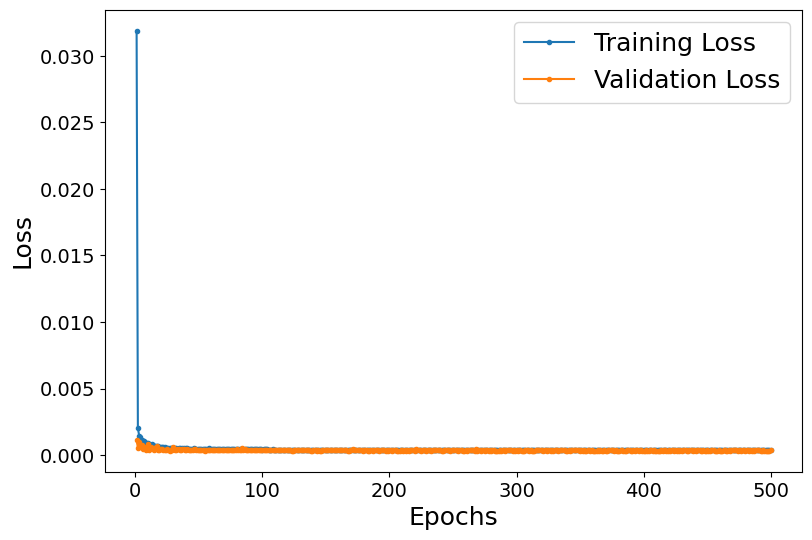

In [15]:
# Extract the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'legend.fontsize': 18,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [9, 6]
   }
plt.rcParams.update(params)


# Create a plot to visualize the training and validation loss
#plt.figure(figsize=(5, 3))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='.')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='.')
#plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.savefig('loss_inv.pdf', format='pdf', dpi=1200)

## Save model

# Creates a HDF5 file 'my_model.h5' 
model.save('robot_model_mpc.keras') # model, [path + "/"] name of model

In [16]:
y_expected = model(X_val)

metric = R2Score()
metric.update_state(np.array(y_val, dtype=np.float32), np.array(y_expected, dtype=np.float32))
result = metric.result()
result

<tf.Tensor: shape=(), dtype=float32, numpy=0.97552514>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

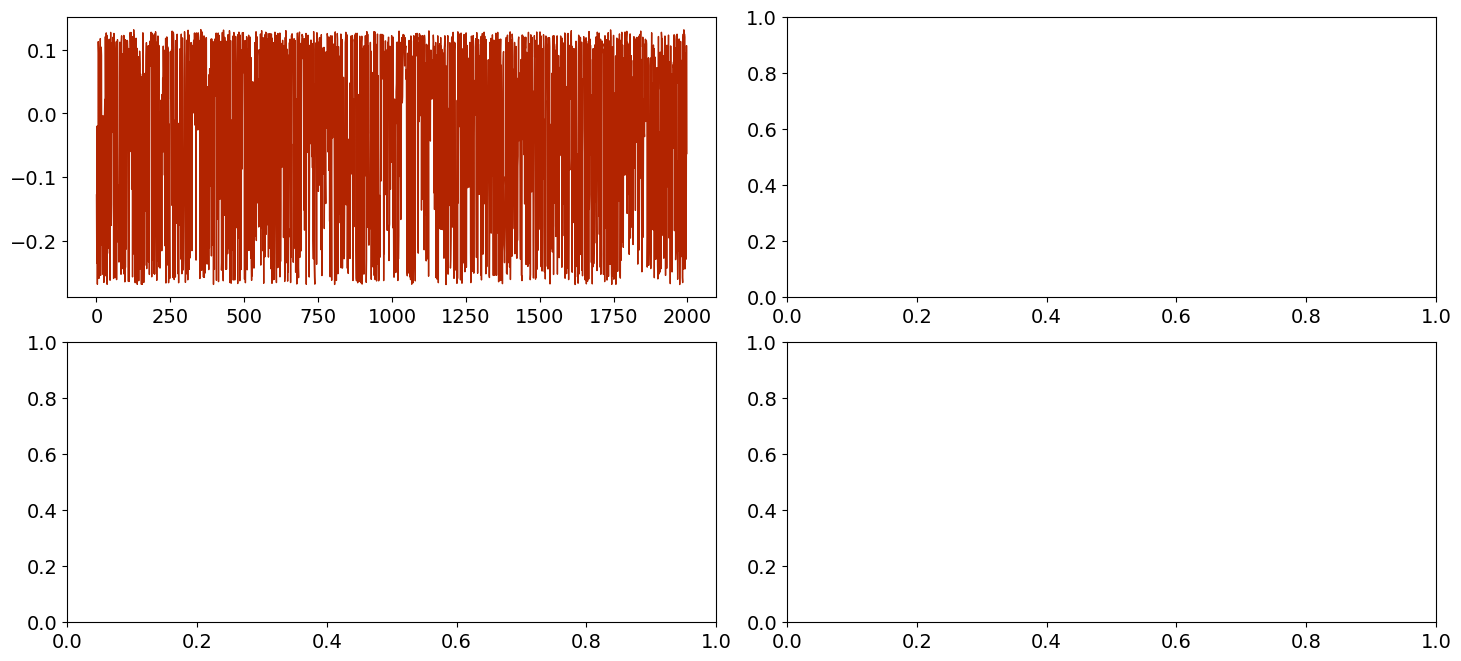

In [17]:
params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [14.5, 6.5]
   }
plt.rcParams.update(params)

fig, axs = plt.subplots(2, 2, layout='constrained')
axs[0,0].plot(y_expected[:,0],linewidth=1, color='#B22400', label='Estimated')
axs[0,0].plot(y_val['x'].tolist(),linewidth=1, linestyle='--', color='#006BB2', label='Target')
axs[0,0].set_xlabel('Sample')
axs[0,0].set_ylabel('q1 [rad]')
axs[0,0].grid(False)
axs[0,0].legend(loc='upper left')

axs[1,0].plot(np.abs(y_expected[:,0]-y_val['KAPPA'].tolist()),linewidth=1, color='#006BB2')
axs[1,0].set_xlabel('Sample')
axs[1,0].set_ylabel('Absolute Error [rad]')
axs[1,0].grid(False)

#######
axs[0,1].plot(y_expected[:,1],linewidth=1, color='#B22400', label='Estimated')
axs[0,1].plot(y_val['y'].tolist(), linewidth=1, linestyle='--', color='#006BB2', label='Target')
axs[0,1].set_xlabel('Sample')
axs[0,1].set_ylabel('q2 [rad]')
axs[0,1].grid(False)
axs[0,1].legend(loc='upper left')

axs[1,1].plot(np.abs(y_expected[:,1]-y_val['PHI'].tolist()),linewidth=1, color='#006BB2')
axs[1,1].set_xlabel('Sample')
axs[1,1].set_ylabel('Absolute Error [rad]')
axs[1,1].grid(False)


plt.savefig('error2.pdf', format='pdf', dpi=1200)

In [18]:
y_expected = model(features)
plt.plot(y_expected[:,:])
plt.plot(smoothed_positions[:,:])

In [31]:
# KFOLD Cross Validation:
num_samples = X_train.shape[0]
#inverse model
# Merge inputs and targets
inputs = np.concatenate((X_train[0:num_samples,:], X_val[0:num_samples,:]), axis=0)
targets = np.concatenate((y_train[0:num_samples], y_val[0:num_samples]), axis=0)
print(inputs.shape)
print(targets.shape)

(1330, 5)
(1330, 2)


In [32]:

def create_model(model_number):
    import tensorflow.keras.backend as K
    if(model_number==0):
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(16, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='tanh'),
        tf.keras.layers.Dense(4, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])
    elif(model_number==1):
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='tanh'),
        tf.keras.layers.Dense(8, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])
    elif(model_number==2):
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(16, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])

    elif(model_number==3):
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])


    elif(model_number==4):
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])

 
    else:
        model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],6)),
        tf.keras.layers.SimpleRNN(32, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(16, activation='tanh'),
        tf.keras.layers.Dense(y_train.shape[1], activation='linear')  # Adjust the output layer as needed
        ])

    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    return model, trainable_count

In [33]:
weights = []
initializers = []


def reinitialize_model(model, new_initializer: tf.keras.initializers.Initializer = None):
    def remove_nones(weights, initializers):
        w = []
        i = []
        for element, initializer in zip(weights, initializers):
            if element is not None:
                w.append(element)
                i.append(initializer)
        return w, i

    global weights, initializers

    for layer in model.layers:
        #print(layer)
        if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D, tf.keras.layers.SimpleRNN)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                             layer.beta_initializer,
                             layer.moving_mean_initializer,
                             layer.moving_variance_initializer]
        elif isinstance(layer, (tf.keras.layers.Reshape,
                                tf.keras.layers.Concatenate,
                                tf.keras.layers.ZeroPadding2D,
                                tf.keras.layers.MaxPool2D,
                                tf.keras.layers.AveragePooling2D,
                                tf.keras.layers.Activation,
                                tf.keras.layers.Add,
                                tf.keras.layers.GlobalAveragePooling2D,
                                tf.keras.layers.Flatten,
                                tf.keras.layers.Dropout

                                )):
            # These layers don't need initialization
            continue
        else:
            raise ValueError('Unhandled layer type: %s' % (type(layer)))

    if new_initializer:
        initializers = [new_initializer for _ in initializers]
    weights, initializers = remove_nones(weights, initializers)
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))

In [34]:
# Define the K-fold Cross Validator
num_models = 5
num_folds = 5
epochs=200
# Define per-fold score containers <-- these are new
loss_per_model_per_fold = np.ndarray((num_models, num_folds))
train_loss = np.ndarray((num_models, num_folds, epochs))
counts = []
kfold = KFold(n_splits=num_folds, shuffle=True)

for ix in range(num_models):
    model, c = create_model(ix)
    # print(model.summary())
    model.compile(optimizer='adam', loss='mean_squared_error')
    counts.append(c)
    fold_no = 0
    for train, test in kfold.split(inputs, targets):


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training Model {ix} for fold {fold_no} ...')
        reinitialize_model(model)
        history = model.fit(inputs[train], targets[train], epochs=epochs, batch_size=128, verbose=0)
        train_loss[ix,fold_no,:]= history.history['loss']

        score = model.evaluate(inputs[test], targets[test])
        # print(f'Loss for Model {ix} fold {fold_no}: {score}')
        loss_per_model_per_fold[ix, fold_no] = score

        # Increase fold number
        fold_no = fold_no + 1


------------------------------------------------------------------------
Training Model 0 for fold 0 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.2108
------------------------------------------------------------------------
Training Model 0 for fold 1 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.3058
------------------------------------------------------------------------
Training Model 0 for fold 2 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.2936
------------------------------------------------------------------------
Training Model 0 for fold 3 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.2583
------------------------------------------------------------------------
Training Model 0 for fold 4 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 1.3863
------------------------------------------------------------------------
Training Model 1 for fold 0 ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.1648
----------------------------------------------

In [35]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(num_models):
#  for j in range(num_folds):
    #print('------------------------------------------------------------------------')
    #print(f'> Model {i} Fold {j} - Loss: {loss_per_model_per_fold[i, j]}')
    #print('------------------------------------------------------------------------')
  print(f'Average scores for all folds in model {i}: Weights: {counts[i]}')
  print(f'> Loss: {np.mean(loss_per_model_per_fold[i,:])} (+- {np.std(loss_per_model_per_fold[i,:])})')
  print('===================================')

------------------------------------------------------------------------
Score per fold
Average scores for all folds in model 0: Weights: 278
> Loss: 0.5016901373863221 (+- 0.4570388797569229)
Average scores for all folds in model 1: Weights: 874
> Loss: 0.2229122042655945 (+- 0.03434695959631176)
Average scores for all folds in model 2: Weights: 3026
> Loss: 0.1616807609796524 (+- 0.024163601019043243)
Average scores for all folds in model 3: Weights: 11170
> Loss: 0.11654874086380004 (+- 0.03807130920665982)
Average scores for all folds in model 4: Weights: 42818
> Loss: 0.06927990242838859 (+- 0.01950886635320586)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


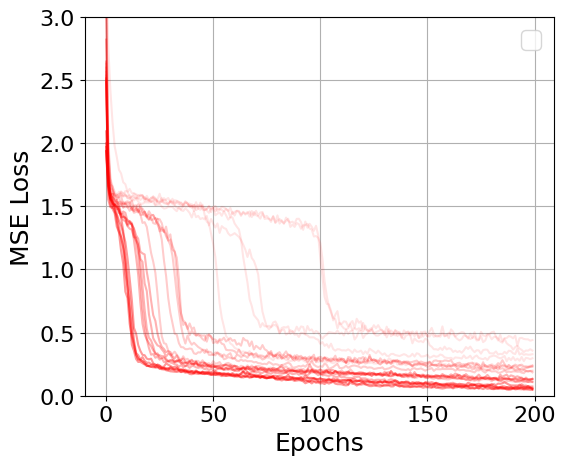

In [41]:

params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [8.5, 6.5]
   }
plt.rcParams.update(params)
# Plot learning curves for each fold
plt.figure(figsize=(6, 5))
for i in range(num_models):
    color = i/(num_models+num_folds)
    for j in range(num_folds):
        plt.plot(train_loss[i,j,:], color='#FF0000', alpha=color)


#plt.title(f'10 Folds Cross Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.ylim(0,3)
#plt.xlim(0,40)

plt.tight_layout()
plt.grid()
plt.savefig('foldsf.pdf', format='pdf', dpi=1200)


In [42]:
from scipy.io import savemat
# Prepare the data for export
# Note: MATLAB requires variable names for stored data. Here, we'll name the data "array_data".
mat_data = {'array_data': train_loss}

# Export the array to a .mat file
savemat('array_data.mat', mat_data)

print('Data has been exported to array_data.mat')

Data has been exported to array_data.mat


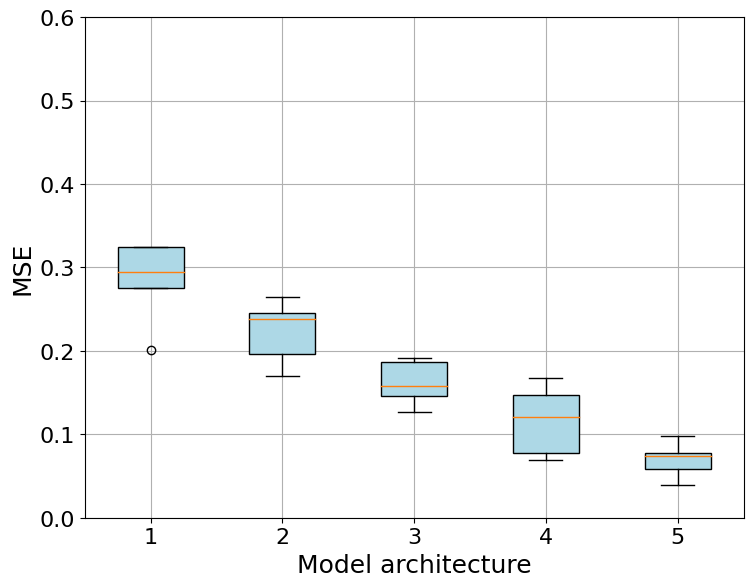

In [48]:
## Plot the box plot
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False   }
plt.rcParams.update(params)

all_data = np.transpose(loss_per_model_per_fold) #[np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = range(1,num_models+1)

# rectangular box plot
bplot1 = plt.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
#plt.title('Rectangular box plot')
plt.plot(labels, counts)
# fill with colors
colors = 'lightblue'
for patch in bplot1['boxes']:
    patch.set_facecolor(colors)

plt.ylim(0,.6)
plt.ylabel('MSE')
plt.xlabel('Model architecture')
plt.grid()

plt.savefig('avg.pdf', format='pdf', dpi=1200)

In [49]:
box_data = {'box_data': all_data}

# Export the array to a .mat file
savemat('box_data.mat', box_data)

print('Data has been exported to box_data.mat')

Data has been exported to box_data.mat
